# Dimensionality reduction

- PCA & UMAP 
- Clustering using spectral clustering

In [1]:
# load in modules
import gzip, pandas as pd, numpy as np, requests, os, gc
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import zipfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

### Load in the data from online location

In [3]:
# download and load GTEx data files
files = {
    # GTEx gene expression data
    'GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz': 'https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz',
    
    # GTEx metadata files
    'GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt': 'https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
    'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt': 'https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
}

# download files 
for filepath, url in files.items():
    if not os.path.exists(filepath):
        try:
            urlretrieve(url, filepath)
        except Exception as e:
            print(f"Error: {e}")
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            else:
                print(f"Failed to download. {response.status_code}")
    else:
        print(f"{filepath} already exists")

GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz already exists
GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt already exists
GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt already exists


In [4]:
# load and process gene expression data
with gzip.open('GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', 'rt') as f:
    gene_exp_df = pd.read_csv(f, sep='\t', skiprows=2)

# look at the shape of the gene expression dataframe
print(f"Gene expression dataset shape: {gene_exp_df.shape}")

Gene expression dataset shape: (56200, 17384)


In [5]:
# get top 5000 most variable genes 
gene_variances = gene_exp_df.select_dtypes(include=['number']).var(axis=1)
top_genes = gene_variances.nlargest(5000).index
gene_exp_df = gene_exp_df.loc[top_genes]
print(f"Top 5000 dataset shape: {gene_exp_df.shape}")

# transpose dataframe so that samples are rows and genes are columns
gene_exp_df = gene_exp_df.set_index('Name').T.reset_index().rename(columns={'index': 'SampleID'})
print(f"Transposed dataset shape: {gene_exp_df.shape}")

Top 5000 dataset shape: (5000, 17384)
Transposed dataset shape: (17383, 5001)


In [6]:
# check dataframe
print(gene_exp_df.head())

Name                  SampleID ENSG00000244734.3 ENSG00000210082.2  \
0                  Description               HBB           MT-RNR2   
1     GTEX-1117F-0226-SM-5GZZ7             452.7            6310.0   
2     GTEX-1117F-0426-SM-5EGHI             225.7           10200.0   
3     GTEX-1117F-0526-SM-5EGHJ             269.6            6111.0   
4     GTEX-1117F-0626-SM-5N9CS            5272.0           11990.0   

Name ENSG00000198804.2 ENSG00000198712.1 ENSG00000198938.2 ENSG00000188536.12  \
0               MT-CO1            MT-CO2            MT-CO3               HBA2   
1              10790.0           11720.0           19890.0              102.4   
2              33610.0           37500.0           62560.0              52.01   
3               9689.0           12250.0           19450.0              62.95   
4               4269.0           10630.0           16440.0             1323.0   

Name ENSG00000198899.2 ENSG00000198886.2 ENSG00000275896.5  ...  \
0              MT-ATP6   

In [7]:
# load metadata files
sample_metadata_df = pd.read_csv('GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t')
phenotype_metadata_df = pd.read_csv('GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t')
print(f"Sample metadata: {sample_metadata_df.shape}")
print(f"Phenotype metadata: {phenotype_metadata_df.shape}")

# make age a continuous variable - use midpoints of age ranges
age_map = {'20-29': 25, '30-39': 35, '40-49': 45, '50-59': 55, '60-69': 65, '70-79': 75}
phenotype_metadata_df['AGE'] = phenotype_metadata_df['AGE'].map(age_map)
print(phenotype_metadata_df[['SUBJID', 'AGE']].head())

Sample metadata: (22951, 63)
Phenotype metadata: (980, 4)
       SUBJID  AGE
0  GTEX-1117F   65
1  GTEX-111CU   55
2  GTEX-111FC   65
3  GTEX-111VG   65
4  GTEX-111YS   65


In [8]:
# merge gene expression, sample metadata, and phenotype metadata
merged_df = gene_exp_df.merge(sample_metadata_df, left_on='SampleID', right_on='SAMPID')
# extract subject ID from sample ID 
merged_df['SUBJID'] = merged_df['SampleID'].str.slice(0, 10)
merged_df = merged_df.merge(phenotype_metadata_df, left_on='SUBJID', right_on='SUBJID')
print(f"Merged dataset shape: {merged_df.shape}")
print(merged_df.head())

Merged dataset shape: (12289, 5068)
                   SampleID ENSG00000244734.3 ENSG00000210082.2  \
0  GTEX-1117F-0226-SM-5GZZ7             452.7            6310.0   
1  GTEX-1117F-0426-SM-5EGHI             225.7           10200.0   
2  GTEX-1117F-0526-SM-5EGHJ             269.6            6111.0   
3  GTEX-1117F-0626-SM-5N9CS            5272.0           11990.0   
4  GTEX-1117F-0726-SM-5GIEN            1617.0           40440.0   

  ENSG00000198804.2 ENSG00000198712.1 ENSG00000198938.2 ENSG00000188536.12  \
0           10790.0           11720.0           19890.0              102.4   
1           33610.0           37500.0           62560.0              52.01   
2            9689.0           12250.0           19450.0              62.95   
3            4269.0           10630.0           16440.0             1323.0   
4           56700.0           39220.0           64660.0              403.5   

  ENSG00000198899.2 ENSG00000198886.2 ENSG00000275896.5  ... SME1PCTS  \
0           13880.0

In [9]:
# save processed merged dataframe as gzipped csv
merged_df.to_csv('GTEx_merged_processed_data.csv.gz', index=False, compression='gzip')

In [10]:
# select gene expression columns
gene_expression_cols = [col for col in merged_df.columns if col.startswith('ENSG')]
print(f"Number of gene expression features: {len(gene_expression_cols)}")

# gene expression matrix for dimensionality reduction
X_genes = merged_df[gene_expression_cols].values
print(f"Gene expression matrix shape: {X_genes.shape}")

# standardize the gene expression data
scaler_genes = StandardScaler()
X_genes_scaled = scaler_genes.fit_transform(X_genes)

Number of gene expression features: 5000
Gene expression matrix shape: (12289, 5000)


In [11]:
#print number of unique tissue types
unique_tissues = merged_df['SMTS'].nunique()
print(f"Number of unique tissue types: {unique_tissues}")

Number of unique tissue types: 27


### PCA
- 2 PCs
- PCs to retain 85% variance

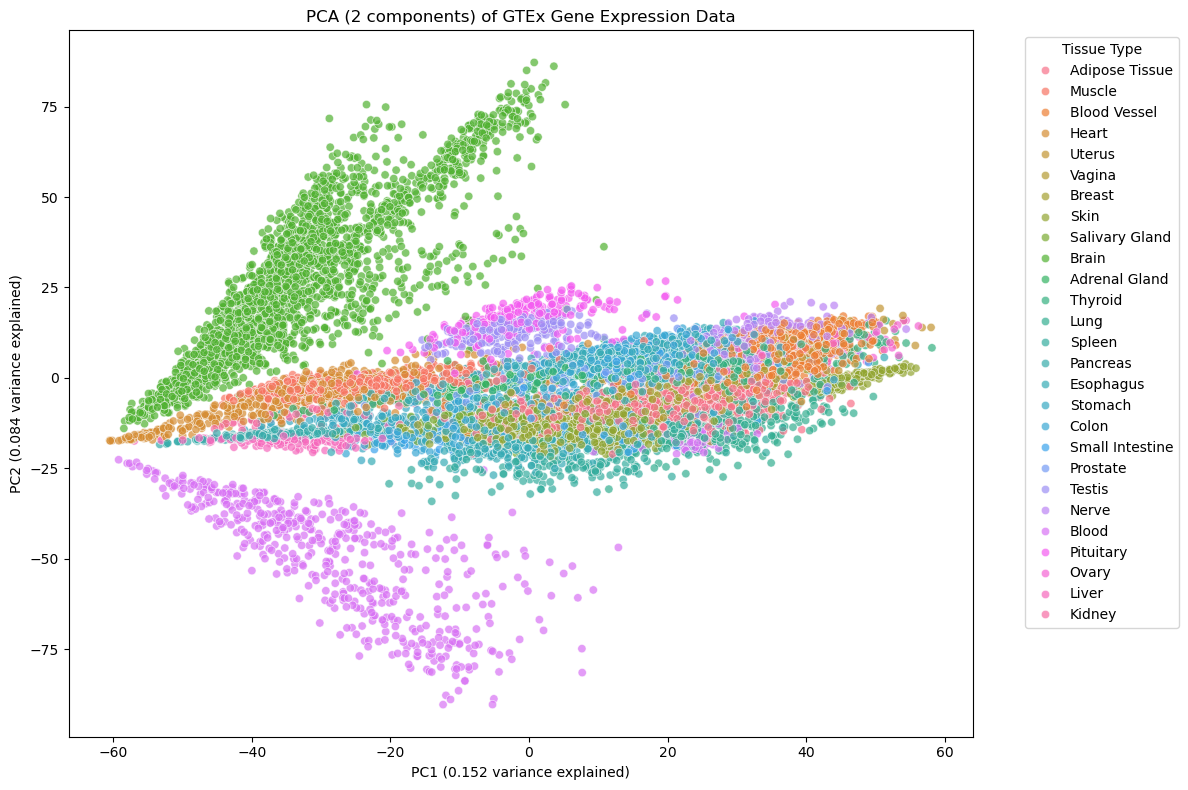

In [12]:
# PCA with 2 components for visualization
pca_2d = PCA(n_components=2, random_state=42)
pca_result_2d = pca_2d.fit_transform(X_genes_scaled)

# add PCA results to dataframe
merged_df['PCA1'] = pca_result_2d[:, 0]
merged_df['PCA2'] = pca_result_2d[:, 1]

# plot PCA results colored by tissue type 
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='PCA1', y='PCA2', hue='SMTS', alpha=0.7)
plt.title('PCA (2 components) of GTEx Gene Expression Data')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance explained)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance explained)')
plt.legend(title='Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Number of components for 85% variance: 83
Explained variance: 0.8502


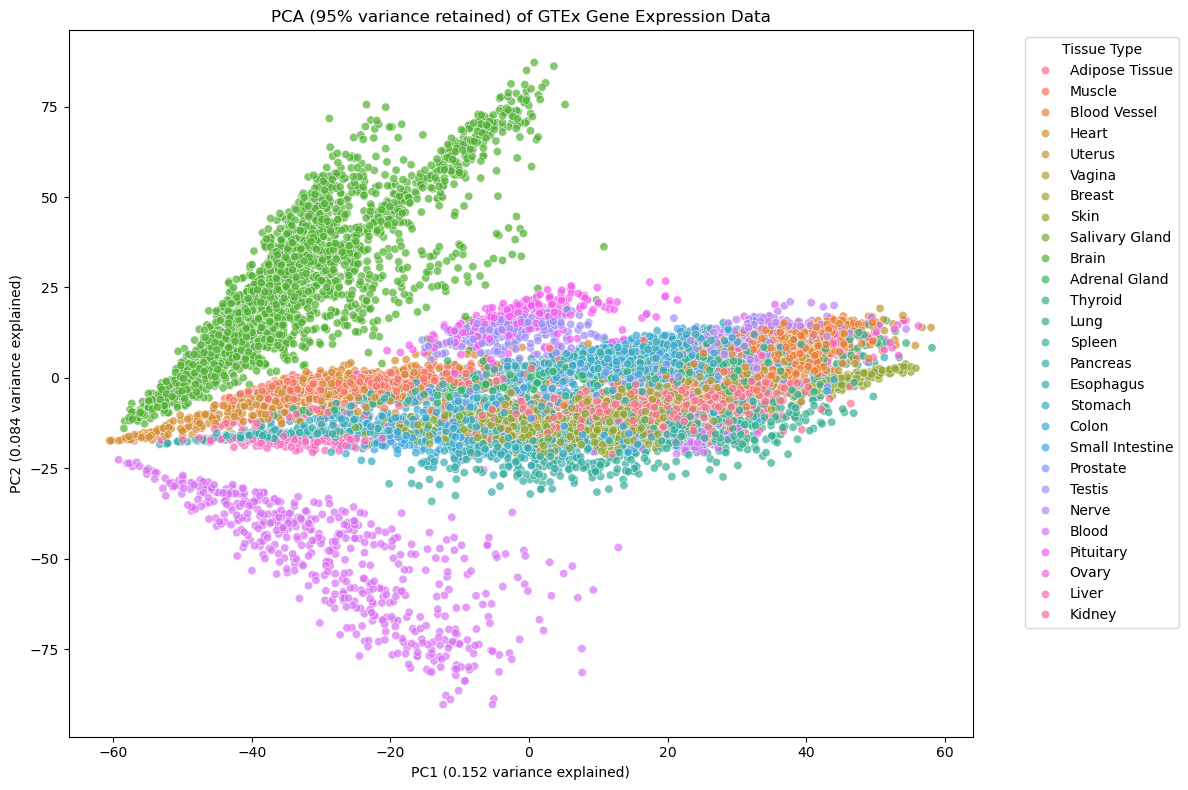

In [13]:
# PCA to retain 85% of variance
pca_85 = PCA(n_components=0.85, random_state=42)
pca_result_85 = pca_85.fit_transform(X_genes_scaled)

print(f"Number of components for 85% variance: {pca_85.n_components_}")
print(f"Explained variance: {pca_85.explained_variance_ratio_.sum():.4f}")

# add first two components to dataframe for visualization
merged_df['PCA1_95'] = pca_result_85[:, 0]
merged_df['PCA2_95'] = pca_result_85[:, 1]

# plot first two components of 95% variance PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='PCA1_95', y='PCA2_95', hue='SMTS', alpha=0.7)
plt.title('PCA (95% variance retained) of GTEx Gene Expression Data')
plt.xlabel(f'PC1 ({pca_85.explained_variance_ratio_[0]:.3f} variance explained)')
plt.ylabel(f'PC2 ({pca_85.explained_variance_ratio_[1]:.3f} variance explained)')
plt.legend(title='Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### UMAP
- 2D PCA
- 85% var PCA

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


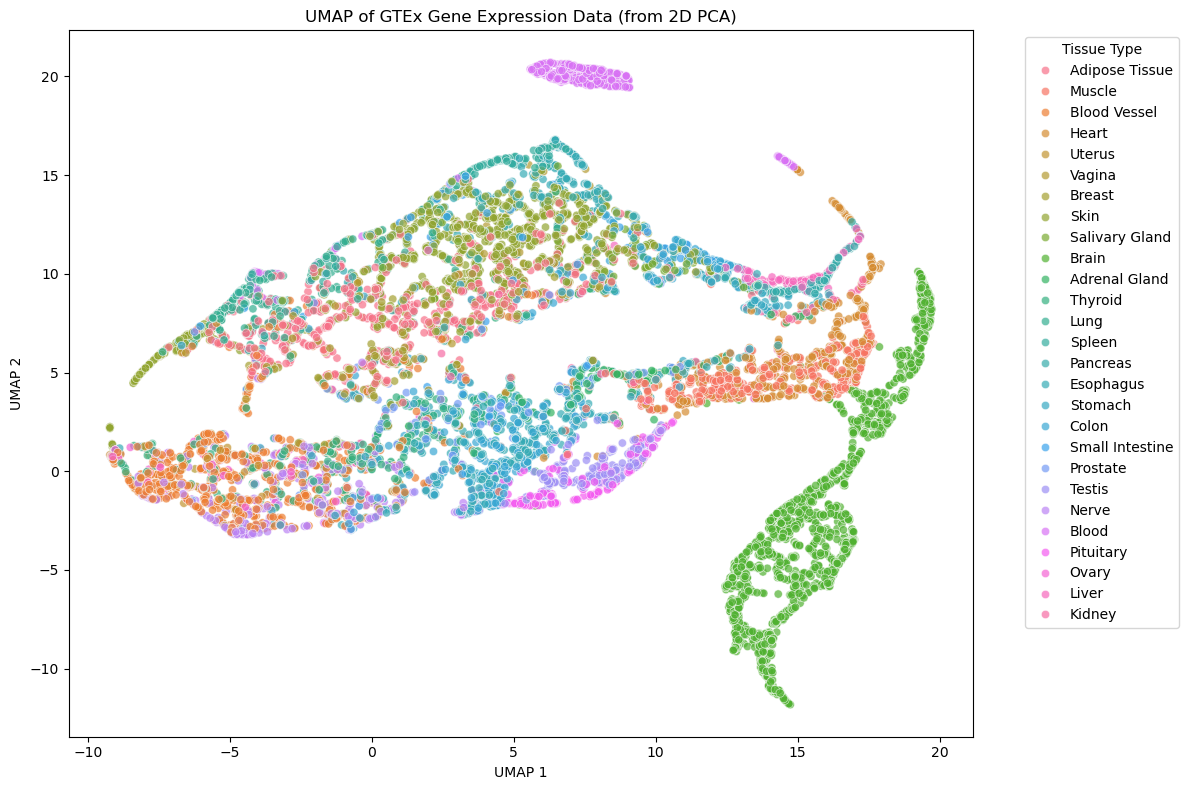

In [14]:
# UMAP on PCA-reduced data (2 components)

reducer_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_result_2d = reducer_2d.fit_transform(pca_result_2d)

# add UMAP results to dataframe
merged_df['UMAP1_from_2D'] = umap_result_2d[:, 0]
merged_df['UMAP2_from_2D'] = umap_result_2d[:, 1]

# plot UMAP results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='UMAP1_from_2D', y='UMAP2_from_2D', hue='SMTS', alpha=0.7)
plt.title('UMAP of GTEx Gene Expression Data (from 2D PCA)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


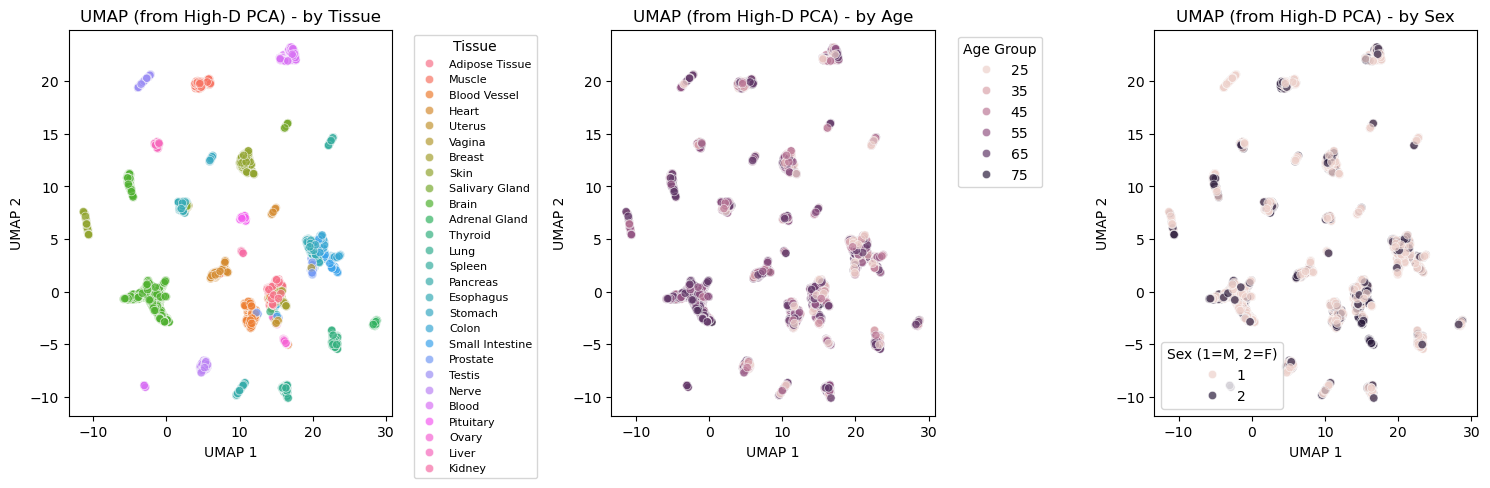

In [16]:
# UMAP on high-dimensional PCA results (85% variance)
reducer_hd = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_result_hd = reducer_hd.fit_transform(pca_result_85)

# add UMAP results to dataframe
merged_df['UMAP1_from_HD'] = umap_result_hd[:, 0]
merged_df['UMAP2_from_HD'] = umap_result_hd[:, 1]

# plot UMAP results
plt.figure(figsize=(15, 5))

# UMAP colored by tissue type
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='UMAP1_from_HD', y='UMAP2_from_HD', hue='SMTS', alpha=0.7)
plt.title('UMAP (from High-D PCA) - by Tissue')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Tissue', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# UMAP colored by age
plt.subplot(1, 3, 2)
age_subset = merged_df[merged_df['AGE'].notna()]
sns.scatterplot(data=age_subset, x='UMAP1_from_HD', y='UMAP2_from_HD', hue='AGE', alpha=0.7)
plt.title('UMAP (from High-D PCA) - by Age')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# UMAP colored by sex
plt.subplot(1, 3, 3)
sex_subset = merged_df[merged_df['SEX'].notna()]
sns.scatterplot(data=sex_subset, x='UMAP1_from_HD', y='UMAP2_from_HD', hue='SEX', alpha=0.7)
plt.title('UMAP (from High-D PCA) - by Sex')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Sex (1=M, 2=F)')

plt.tight_layout()
plt.show()

### UMAP -> Spectral clustering

In [17]:
# spectral clustering - 2D PCA -> UMAP
spectral_2d = SpectralClustering(n_clusters=27, affinity='nearest_neighbors', random_state=42)
spectral_labels_2d = spectral_2d.fit_predict(umap_result_2d) 
print(f"\nSpectral Clustering Results:")
cluster_counts = Counter(spectral_labels_2d)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples")

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Clustering Results:
Cluster 7: 659 samples
Cluster 11: 558 samples
Cluster 2: 640 samples
Cluster 19: 761 samples
Cluster 5: 671 samples
Cluster 0: 632 samples
Cluster 23: 535 samples
Cluster 6: 1058 samples
Cluster 9: 783 samples
Cluster 8: 451 samples
Cluster 24: 426 samples
Cluster 12: 347 samples
Cluster 15: 325 samples
Cluster 4: 1185 samples
Cluster 17: 265 samples
Cluster 13: 891 samples
Cluster 10: 285 samples
Cluster 3: 279 samples
Cluster 26: 143 samples
Cluster 14: 122 samples
Cluster 1: 701 samples
Cluster 21: 140 samples
Cluster 25: 63 samples
Cluster 20: 74 samples
Cluster 16: 62 samples
Cluster 18: 219 samples
Cluster 22: 14 samples


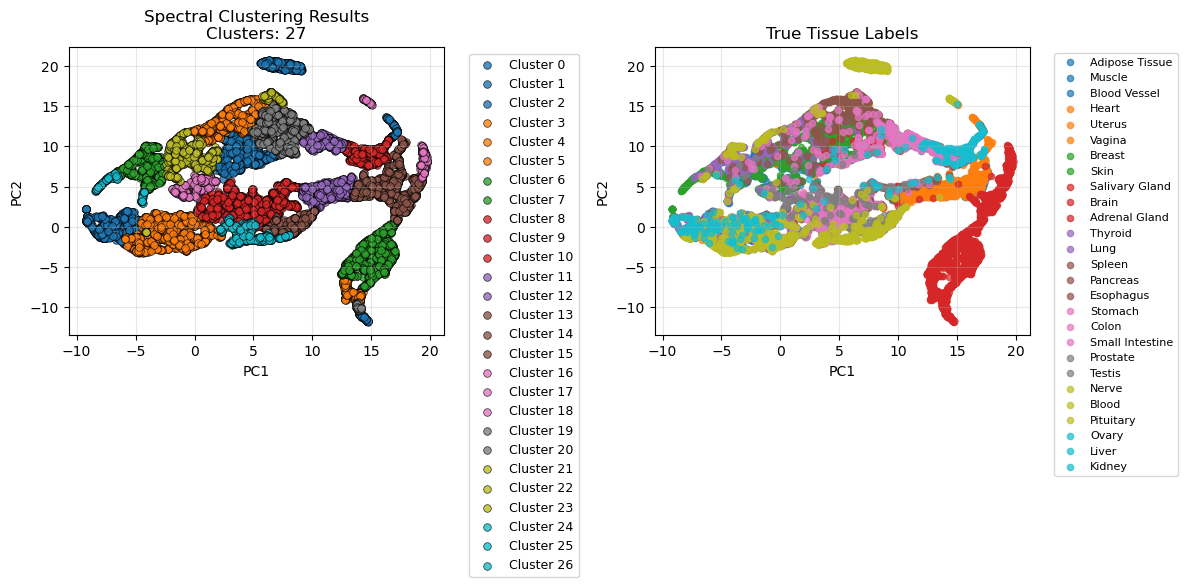

In [18]:
tissue_labels = merged_df['SMTS']

plt.figure(figsize=(12, 5))

# clustering results - color by cluster
plt.subplot(1, 2, 1)
unique_labels_spectral = set(spectral_labels_2d)
n_clusters_spectral = len(unique_labels_spectral)
# colors for each cluster
cluster_colors_spectral = plt.cm.tab10(np.linspace(0, 1, max(10, n_clusters_spectral)))
for i, k in enumerate(sorted(unique_labels_spectral)):
    class_member_mask = (spectral_labels_2d == k)
    xy = umap_result_2d[class_member_mask]
    color_idx = k % len(cluster_colors_spectral)
    plt.scatter(xy[:, 0], xy[:, 1], c=[cluster_colors_spectral[color_idx]], marker='o', 
               s=30, alpha=0.8, label=f'Cluster {k}', edgecolors='black', linewidth=0.5)
plt.title(f'Spectral Clustering Results\nClusters: {n_clusters_spectral}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)

# ground truth tissue plot
plt.subplot(1, 2, 2)
unique_tissues = tissue_labels.unique()
tissue_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_tissues)))
for i, tissue in enumerate(unique_tissues):
    tissue_mask = (tissue_labels == tissue)
    xy = umap_result_2d[tissue_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[tissue_colors[i]], marker='o', s=20, alpha=0.7, label=tissue)

plt.title('True Tissue Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# spectral clustering - high D PCA -> UMAP
spectral_hd = SpectralClustering(n_clusters=27, affinity='nearest_neighbors', random_state=42)
spectral_labels_hd = spectral_hd.fit_predict(umap_result_hd) 
print(f"\nSpectral Clustering Results:")
cluster_counts = Counter(spectral_labels_hd)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples")

/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Clustering Results:
Cluster 1: 1862 samples
Cluster 19: 1300 samples
Cluster 23: 393 samples
Cluster 0: 3050 samples
Cluster 5: 128 samples
Cluster 12: 2030 samples
Cluster 21: 141 samples
Cluster 7: 356 samples
Cluster 13: 419 samples
Cluster 2: 107 samples
Cluster 4: 142 samples
Cluster 6: 181 samples
Cluster 17: 56 samples
Cluster 18: 287 samples
Cluster 3: 123 samples
Cluster 9: 181 samples
Cluster 24: 299 samples
Cluster 20: 148 samples
Cluster 16: 147 samples
Cluster 15: 157 samples
Cluster 8: 82 samples
Cluster 25: 49 samples
Cluster 14: 335 samples
Cluster 11: 52 samples
Cluster 10: 92 samples
Cluster 26: 86 samples
Cluster 22: 86 samples


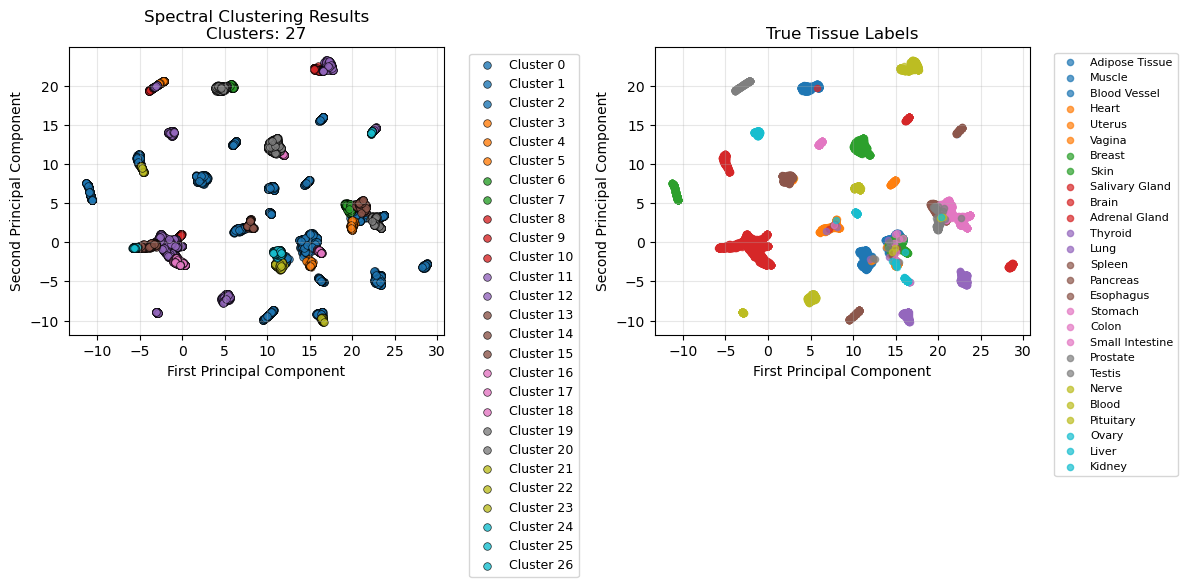

In [20]:
tissue_labels = merged_df['SMTS']

plt.figure(figsize=(12, 5))

# clustering results - color by cluster
plt.subplot(1, 2, 1)
unique_labels_spectral = set(spectral_labels_hd)
n_clusters_spectral = len(unique_labels_spectral)
# colors for each cluster
cluster_colors_spectral = plt.cm.tab10(np.linspace(0, 1, max(10, n_clusters_spectral)))
for i, k in enumerate(sorted(unique_labels_spectral)):
    class_member_mask = (spectral_labels_hd == k)
    xy = umap_result_hd[class_member_mask]
    color_idx = k % len(cluster_colors_spectral)
    plt.scatter(xy[:, 0], xy[:, 1], c=[cluster_colors_spectral[color_idx]], marker='o', 
               s=30, alpha=0.8, label=f'Cluster {k}', edgecolors='black', linewidth=0.5)
plt.title(f'Spectral Clustering Results\nClusters: {n_clusters_spectral}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)

# ground truth tissue plot
plt.subplot(1, 2, 2)
unique_tissues = tissue_labels.unique()
tissue_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_tissues)))
for i, tissue in enumerate(unique_tissues):
    tissue_mask = (tissue_labels == tissue)
    xy = umap_result_hd[tissue_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[tissue_colors[i]], marker='o', s=20, alpha=0.7, label=tissue)

plt.title('True Tissue Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Latent space evaluation

In [21]:
# compare spectral clustering latent spaces based on tissue grouping ability

# get tissue labels
tissue_labels = merged_df['SMTS']
tissue_encoder = {tissue: idx for idx, tissue in enumerate(tissue_labels.unique())}
tissue_encoded = [tissue_encoder[tissue] for tissue in tissue_labels]

In [22]:
# calculate key evaluation metrics
def evaluate_approach(true_labels, cluster_labels, name):
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"{name}:")
    print(f"  ARI: {ari:.4f}")
    print(f"  NMI: {nmi:.4f}")
    return {'ARI': ari, 'NMI': nmi}

# evaluate both approaches
metrics_2d = evaluate_approach(tissue_encoded, spectral_labels_2d, "2D PCA -> UMAP -> Spectral")
metrics_hd = evaluate_approach(tissue_encoded, spectral_labels_hd, "High-D PCA -> UMAP -> Spectral")
print()

2D PCA -> UMAP -> Spectral:
  ARI: 0.2854
  NMI: 0.5101
High-D PCA -> UMAP -> Spectral:
  ARI: 0.2698
  NMI: 0.6400



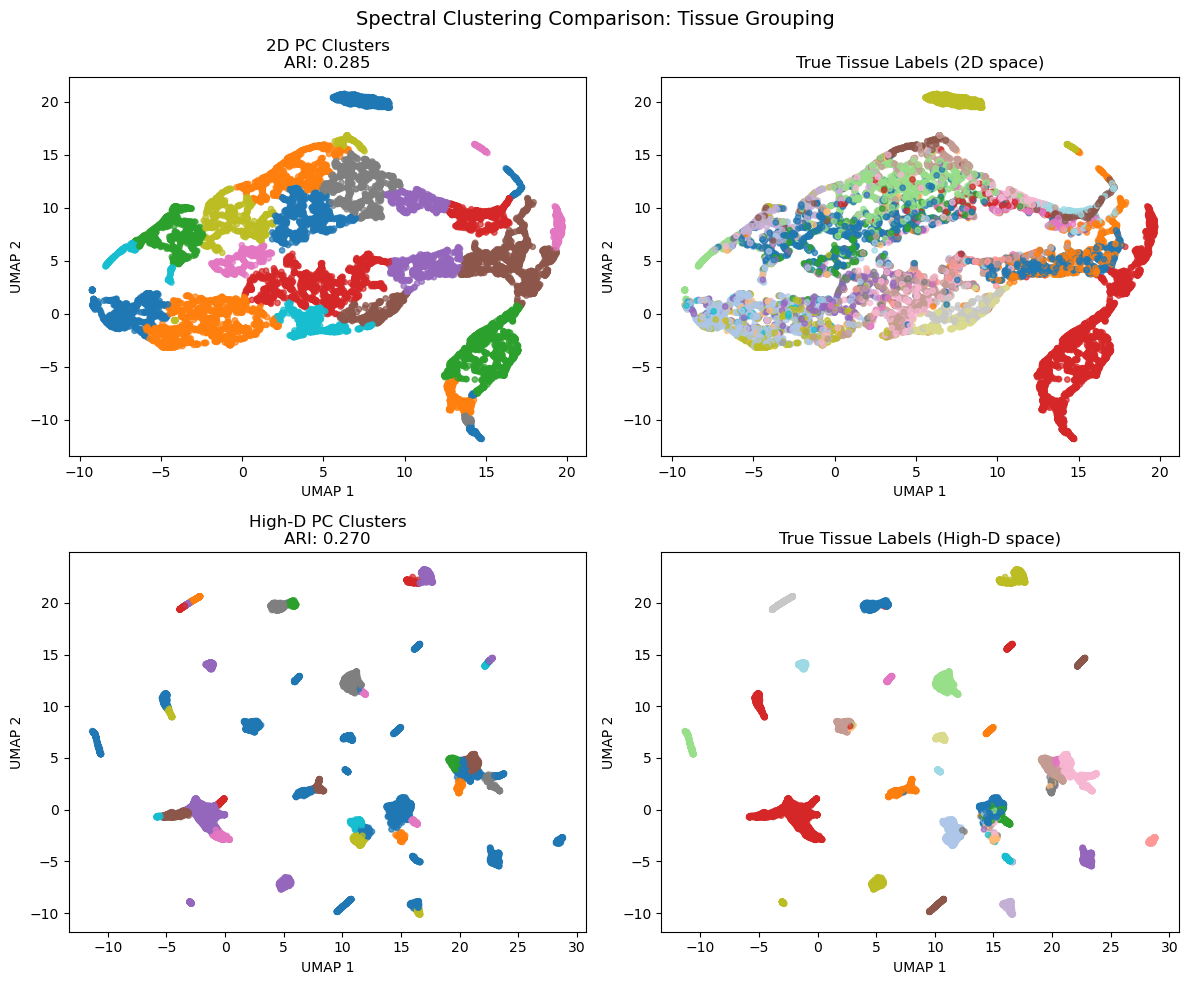

In [23]:
# visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Spectral Clustering Comparison: Tissue Grouping', fontsize=14)

# 2D approach
ax = axes[0, 0]
ax.scatter(umap_result_2d[:, 0], umap_result_2d[:, 1], c=spectral_labels_2d, cmap='tab10', alpha=0.7, s=15)
ax.set_title(f'2D PC Clusters\nARI: {metrics_2d["ARI"]:.3f}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

ax = axes[0, 1]
ax.scatter(umap_result_2d[:, 0], umap_result_2d[:, 1], c=tissue_encoded, cmap='tab20', alpha=0.7, s=15)
ax.set_title('True Tissue Labels (2D space)')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# High-D approach
ax = axes[1, 0]
ax.scatter(umap_result_hd[:, 0], umap_result_hd[:, 1], c=spectral_labels_hd, cmap='tab10', alpha=0.7, s=15)
ax.set_title(f'High-D PC Clusters\nARI: {metrics_hd["ARI"]:.3f}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

ax = axes[1, 1]
ax.scatter(umap_result_hd[:, 0], umap_result_hd[:, 1], c=tissue_encoded, cmap='tab20', alpha=0.7, s=15)
ax.set_title('True Tissue Labels (High-D space)')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

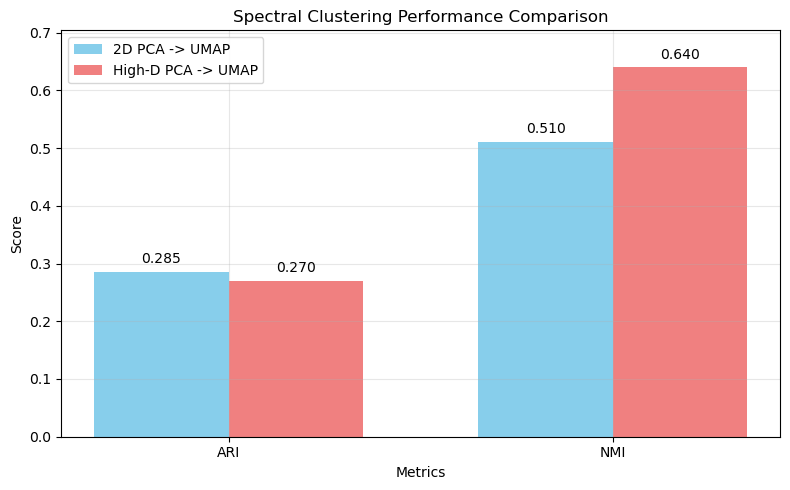

In [25]:
# metrics comparison
plt.figure(figsize=(8, 5))
metrics = ['ARI', 'NMI']
values_2d = [metrics_2d['ARI'], metrics_2d['NMI']]
values_hd = [metrics_hd['ARI'], metrics_hd['NMI']]

metric_len = np.arange(len(metrics))
width = 0.35

plt.bar(metric_len - width/2, values_2d, width, label='2D PCA -> UMAP', color='skyblue')
plt.bar(metric_len + width/2, values_hd, width, label='High-D PCA -> UMAP', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Spectral Clustering Performance Comparison')
plt.xticks(metric_len, metrics)
plt.ylim(0, max(max(values_2d), max(values_hd)) * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

# add value labels
for i, (v2d, vhd) in enumerate(zip(values_2d, values_hd)):
    plt.text(i - width/2, v2d + 0.01, f'{v2d:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, vhd + 0.01, f'{vhd:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
# summary
print("Summary")
print(f"2D PCA -> UMAP -> Spectral:     ARI = {metrics_2d['ARI']:.4f}, NMI = {metrics_2d['NMI']:.4f}")
print(f"High-D PCA -> UMAP -> Spectral: ARI = {metrics_hd['ARI']:.4f}, NMI = {metrics_hd['NMI']:.4f}")

# determine better approach
if metrics_hd['ARI'] > metrics_2d['ARI']:
    better = "High-D PCA approach"
    improvement = (metrics_hd['ARI'] - metrics_2d['ARI']) / metrics_2d['ARI'] * 100
else:
    better = "2D PCA approach"
    improvement = (metrics_2d['ARI'] - metrics_hd['ARI']) / metrics_hd['ARI'] * 100

print(f"\nBest approach: {better}")

Summary
2D PCA -> UMAP -> Spectral:     ARI = 0.2854, NMI = 0.5101
High-D PCA -> UMAP -> Spectral: ARI = 0.2698, NMI = 0.6400

Best approach: 2D PCA approach


### The dimensionality reduction method with 2PCs -> UMAP performed better than high variance PCs -> UMAP according to a slightly greater ARI score (0.285 > 0.270). Although the NMI score for the high dimensional PCA method was greater, ARI was ultimately used to assess clustering assignments by tissue origin because ARI considers clustering correctness more than NMI.

In [27]:
# save latent spaces 
np.savez_compressed('gtex_latent_spaces.npz',
                    pca_2d=pca_result_2d,
                    pca_hd=pca_result_85,
                    umap_from_2d=umap_result_2d,
                    umap_from_hd=umap_result_hd)